<a href="https://colab.research.google.com/github/rsuseno2907/two-photon-imaging/blob/main/winterSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy import stats
from PIL import Image
import os
import matplotlib.pyplot as plt
import fnmatch
import cv2 as cv
import importlib
import pylab
from skimage import io
import pickle
import sklearn.preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/Shared drives/Capstoone")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pytiff

In [ ]:
import pytiff
import tifffile
imPath = "lt3_000_002_rigid.tif"

dim of stacks: (1100, 512, 796)
(512, 796, 1100)


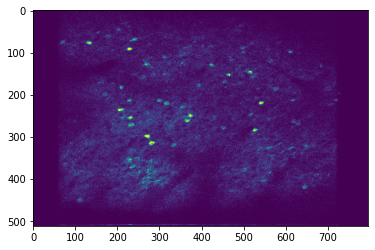

In [ ]:


""" Return an np.array object by reading into the frames  """ 

# key = frames from 0-1000, increment = 1, without skipping
img_stacks = tifffile.imread(imPath, key=range(5000,6100, 1))
print("dim of stacks:", img_stacks.shape)
# show the first frame 
plt.imshow(img_stacks[0])
data1 = np.moveaxis(img_stacks,0,-1) #swap so the images are stacked in the z-direction instead of x
print(data1.shape)

(512, 796, 1100)


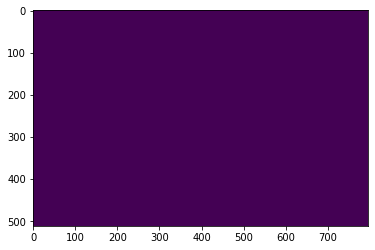

In [ ]:
zdata = stats.zscore(data1, axis=2) #with mean=0 and std=1
print(zdata.shape)
filename = "cmap_6000.pkl"
newMap = True

if newMap:
    cm = np.zeros([zdata.shape[0],zdata.shape[1]])
else:
    with open(filename, 'rb') as f:
        cm = pickle.load(f)
    print(cm.shape)
    plt.imshow(cm)

plt.imshow(cm)

run
run
run
run
run
run
run
run


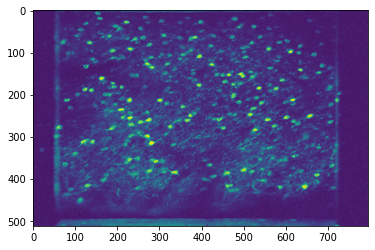

In [ ]:
# correlation map

#shift: i and j represent displacements with respect to a given pixel
#After you shift zdata, you are aligning each pixel with one of its neighbors (loop accumulates for all 8 neightbors)
#already z-scored, sum yields the empirical correlation coefficient between the pixels.  

for i in [-1,0,1]: 
    for j in [-1,0,1]:
        if i!=0 or j!=0:
            cm = cm + np.squeeze(np.sum(zdata*np.roll(zdata,[i,j,0]),2)) 
            print("run")

cm = cm/8/data1.shape[2] #normalize data
plt.imshow(cm)
with open(filename,'wb') as f:
    pickle.dump(cm,f)


In [ ]:
cm[290][520]

0.37720050122519083

In [ ]:
import cv2 as cv

thres = threshold_otsu(cm)

#plt.imshow(cm)
#print(cm.dtype)
#cm = cm.astype(uint8_t)

#plt.imshow(img)
ret, thresh = cv.threshold(img,0,255,cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
plt.imshow(thresh)


NameError: ignored

In [ ]:
#PRE-PROCESSING
kernel = np.ones((3,3),np.uint8) #TODO try out diff kernels
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel,iterations=5) #OPTI [1-10]
#plt.imshow(opening)

# sure background area, dilate background == erode object
sure_bg = cv.dilate(opening,kernel,iterations=1) #OPTI [1-5]
#plt.imshow(sure_bg)

# Finding sure foreground area
dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5) 
ret, sure_fg = cv.threshold(dist_transform,0.04*dist_transform.max(),
                            255,cv.THRESH_BINARY_INV) #OPTI [0.01 - 0.1]

#ret, sure_fg = cv.threshold(dist_transform,0,255,cv.THRESH_BINARY)
#plt.imshow(sure_fg)
#sure_fg = cv.bitwise_not(sure_fg)
plt.imshow(sure_fg)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)
#plt.imshow(unknown)

In [ ]:
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    #cv.imshow('labeled.png', labeled_img)
    plt.imshow(labeled_img)

In [ ]:
import sys
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg) #labels background with 0 and all else with integers from 1
#imshow_components(markers)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
#imshow_components(markers)

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

imshow_components(markers)

In [ ]:
#WATERSHED#
backtobgr = cv.cvtColor(cm,cv.COLOR_GRAY2BGR) # cm was in grayscale + .watershed works on bgr, so convert to bgr
print(backtobgr.shape)
#plt.imshow(backtobgr)

markers = cv.watershed(backtobgr,markers)
backtobgr[markers == -1] = [255,0,0]
plt.imshow(markers)

final = cv.cvtColor(backtobgr, cv.COLOR_BGR2GRAY) # convert back to grayscale for comparison 
#plt.imshow(final, cmap="gray")
erodeFinal = cv.erode(final,kernel,iterations=2)
erodeFinal[erodeFinal>0] = 255
#plt.imshow(erodeFinal, cmap="gray")

print(erodeFinal.shape)
#print("Number of labels =",erodeFinal.max())

#finalroi = final[200:300,200:300]
#print(finalroi.min())
#plt.imshow(finalroi, cmap="gray")
#print(finalroi[55,30])

#im = Image.fromarray(erodeFinal)
#im.save('ourMask255_i3.png')

In [ ]:
#correct is ground truth, predicted is output from our segmentation
#confused as to what metric we should be reporting, I'm assuming it's the 1.0 row of precision/recall/f1-score since that class represents the actual cells as opposed to 0 column (background)
correct = image.imread("lt3_000_002_GT.png")
cm[cm>0] = 1
predicted = cm
correct_flat = [item for sublist in correct for item in sublist]
predicted_flat = [item for sublist in predicted for item in sublist]
from sklearn.metrics import classification_report
print(classification_report(correct_flat, predicted_flat))